# 特徴量重要度（Feature Importance）を可視化

In [4]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [5]:
# Titanicデータセット読み込み
titanic = pd.read_csv("./data/train.csv")

In [8]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [11]:
# 説明変数と目的変数
y = titanic["Survived"]
X = titanic[["Pclass", "Sex", "Age", "Fare"]]


In [12]:

# 欠損値処理
X["Age"] = X["Age"].fillna(X["Age"].mean())
X["Fare"] = X["Fare"].fillna(X["Fare"].mean())

# One-Hotエンコーディング
X = pd.get_dummies(X, drop_first=True)

# train/test分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# LightGBMデータセット
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# パラメータ設定
params = {
    "objective": "binary",
    "metric": "binary_error",
    "verbosity": -1,
    "seed": 42
}


/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_81269/2102066365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Age"] = X["Age"].fillna(X["Age"].mean())
/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_81269/2102066365.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Fare"] = X["Fare"].fillna(X["Fare"].mean())


In [14]:

# 学習
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=10)],
)

# 予測精度
y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred_prob]
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# 特徴量重要度取得
importance = model.feature_importance(importance_type='gain')
feature_names = X.columns

# DataFrame化
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values(by="importance", ascending=False)


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_error: 0.134831	valid_1's binary_error: 0.195531
Accuracy: 0.8045


/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_81269/533743151.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importance_df, palette="viridis")


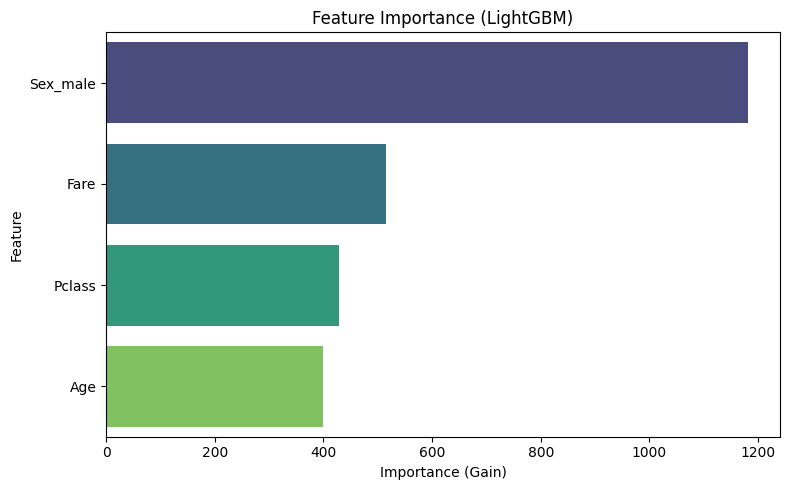

In [15]:

# 可視化
plt.figure(figsize=(8, 5))
sns.barplot(x="importance", y="feature", data=importance_df, palette="viridis")
plt.title("Feature Importance (LightGBM)")
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
